In [3]:
from keras.datasets import boston_housing




In [4]:
(train_data, train_target), (test_data, test_target) = boston_housing.load_data() 


57026/57026 [==============================] - 0s 0us/step


In [5]:
import pandas as pd

pd.DataFrame(train_data)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79


In [6]:
import numpy as np

train_mean = np.mean(train_data, axis=0)
train_data -= train_mean

train_std = np.std(train_data, axis=0)
train_data /= train_std

test_data -= train_mean
test_data /= train_std


In [7]:
from keras import layers, models, losses, optimizers

def make_model():

    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [8]:
def kFold(k, num_val_samples, num_epochs):

    all_scores = []

    for i in range(k):
        print("Fold #" + str(i))

        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_target = train_target[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                            train_data[(i + 1) * num_val_samples:]], 
                                            axis=0)

        partial_train_target = np.concatenate([train_target[:i * num_val_samples],
                                                train_target[(i + 1) * num_val_samples:]],
                                                axis=0)
        
        model = make_model()

        model.fit(partial_train_data, partial_train_target,epochs=num_epochs, batch_size=1, verbose=0)
        val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
        
        all_scores.append(val_mae)

    return all_scores


In [9]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100

all_scores = kFold(k, num_val_samples, num_epochs)

all_scores


Fold #0
Fold #1
Fold #2
Fold #3


[2.3856399059295654, 2.6351590156555176, 2.648066997528076, 2.4532508850097656]

In [10]:
all_mae_histories = []

for i in range(k):
    print("Fold #" + str(i))

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_target = train_target[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                        train_data[(i + 1) * num_val_samples:]], 
                                        axis=0)

    partial_train_target = np.concatenate([train_target[:i * num_val_samples],
                                            train_target[(i + 1) * num_val_samples:]],
                                            axis=0)
    
    model = make_model()

    history = model.fit(partial_train_data, partial_train_target,
        validation_data=(val_data, val_target),
        epochs=500, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)

    all_mae_histories.append(mae_history)


Fold #0
Fold #1
Fold #2
Fold #3


In [11]:
len(all_mae_histories[0])
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(500)]


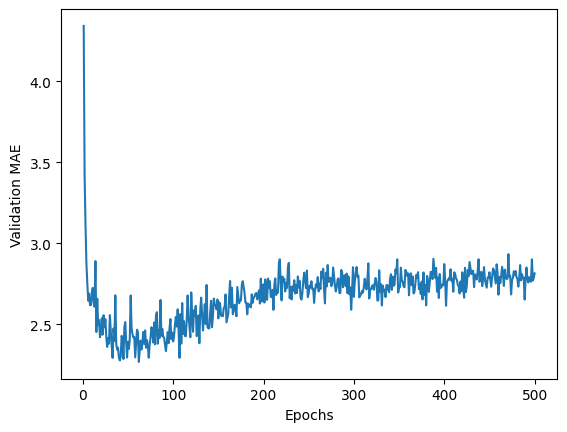

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


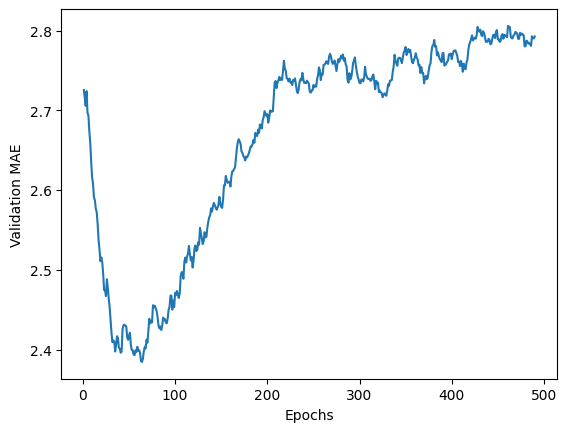

In [14]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [15]:
model = make_model()

model.fit(train_data, train_target,epochs=80, batch_size=16)


Epoch 1/80
26/26 [==============================] - 1s 2ms/step - loss: 494.2640 - mae: 20.1898
Epoch 2/80
26/26 [==============================] - 0s 2ms/step - loss: 333.9559 - mae: 15.6920
Epoch 3/80
26/26 [==============================] - 0s 2ms/step - loss: 180.5632 - mae: 10.7426
Epoch 4/80
26/26 [==============================] - 0s 2ms/step - loss: 87.0691 - mae: 6.8836
Epoch 5/80
26/26 [==============================] - 0s 2ms/step - loss: 49.3875 - mae: 5.0028
Epoch 6/80
26/26 [==============================] - 0s 2ms/step - loss: 33.2696 - mae: 4.0409
Epoch 7/80
26/26 [==============================] - 0s 2ms/step - loss: 25.7467 - mae: 3.6052
Epoch 8/80
26/26 [==============================] - 0s 2ms/step - loss: 21.4194 - mae: 3.2804
Epoch 9/80
26/26 [==============================] - 0s 2ms/step - loss: 19.1235 - mae: 3.1009
Epoch 10/80
26/26 [==============================] - 0s 2ms/step - loss: 17.6953 - mae: 2.9680
Epoch 11/80
26/26 [==============================] - 

In [16]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_target)


4/4 [==============================] - 0s 3ms/step - loss: 16.9679 - mae: 2.7263
